In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from itertools import compress
plt.rcParams['figure.figsize'] = [18, 9]

# FULL ALGORITHM

In [47]:
def load_groundtruth(directory: str, images):
    image_positions = pd.read_csv("images/labels_people_detection.csv",delimiter=",",usecols=["Image","X","Y"])

    image_count = pd.DataFrame(columns=["Image","NPeople"])

    for img in images:
        if img not in np.unique(image_positions["Image"]):
            image_count = image_count._append({"Image": img, "NPeople": 0}, ignore_index=True)

    for img in np.unique(image_positions["Image"]):
        n_people = np.sum(image_positions["Image"] == img)
        image_count = image_count._append({"Image": img,"NPeople": n_people}, ignore_index=True)
    
    return image_positions, image_count
    
    
def load_data(directory: str):
    image_filenames = os.listdir(directory)
    image_filenames.sort()
    image_filenames.pop()
    
    image_positions, image_count = load_groundtruth(directory, image_filenames)
    
    for i in range(len(image_filenames)):
        image_filenames[i] = "{}/{}".format(directory,image_filenames[i])
    
    image_stack = np.stack([cv2.imread(filename, cv2.IMREAD_GRAYSCALE) for filename in image_filenames], axis=2)
    image_stack = np.transpose(image_stack, (2, 0, 1))
    
    image_stack_color = np.stack([cv2.cvtColor(cv2.imread(filename, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) for filename in image_filenames], axis=2)
    image_stack_color = np.transpose(image_stack_color, (2, 3, 0, 1))
    
    return image_stack, image_stack_color, image_positions, image_count

# original_img = image_stack[idx]
def compute_tophat(original_img, empty_img):
    clahe = cv2.createCLAHE(clipLimit=1)

    empty_img_ = empty_img.copy()
    empty_img_[0:440,:] = 0
    
    image_mod_ = original_img.copy()
    image_mod_[0:440,:] = 0
    
    empty_image_ = clahe.apply(empty_img_)
    test_image_ = clahe.apply(image_mod_)
    
    diff = cv2.subtract(empty_image_, test_image_)
    
    kernelSize = (10,18)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
    tophat = cv2.morphologyEx(diff, cv2.MORPH_TOPHAT, kernel)

    return tophat, diff


def detection_mask(image, tophat):
    edges = cv2.Canny(image=tophat, threshold1=100, threshold2=200)

    dilated = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,10)))

    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,10)))

    image_used = np.copy(image)

    image_used[0][closed == 0] = 0
    image_used[1][closed == 0] = 0
    image_used[2][closed == 0] = 0

    image_used = np.transpose(image_used, (1, 2, 0))
    
    mask = skin_color_filter(image_used)
    
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (7,7)))
    
    #mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,10)))

    
    result = np.copy(image)
    result[0][mask == 255] = 0
    result[1][mask == 255] = 255
    result[2][mask == 255] = 0
    result = np.transpose(result, (1, 2, 0))
    
    return result, mask[440:,:]
    
    
def skin_color_filter(image):
    min_YCrCb = np.array([0, 133, 77], np.uint8)
    max_YCrCb = np.array([235, 173, 127], np.uint8)

    #img2 = cv2.imread("images/{}".format(images[5]), cv2.IMREAD_COLOR)
    imageYCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    skinRegionYCrCb = cv2.inRange(imageYCrCb, min_YCrCb, max_YCrCb)

    #skinYCrCb = cv2.bitwise_and(image, image, mask=skinRegionYCrCb)
    
    return skinRegionYCrCb

# ------------------------------------------------------------
# ------------------------------------------------------------

def min_max_norm(image):
    min_val = np.min(image)
    max_val = np.max(image)

    norm_image = (image - min_val) / (max_val - min_val)
    return norm_image


def divide_img_sectors(image):
    # Find boundaries
    
    img_size = image.shape
    sqrt_arr = np.sqrt(np.linspace(1,img_size[0],8, dtype = np.int_))
    norm_arr = min_max_norm(sqrt_arr)
    cut_boundaries = img_size[0] - (norm_arr * img_size[0]).astype(int)

    
    tmp = np.repeat(cut_boundaries, 2)[1:-1]
    cut_boundaries_paris = tmp[:(len(tmp) // 2 + 1) * 2].reshape(-1, 2)
    image_list_sectors = []

    for pair_i in cut_boundaries_paris:
        img = image[pair_i[1]:pair_i[0],:].copy()
        image_list_sectors.append(img)

    return image_list_sectors

def filter_blobs(bin_image,thresh_area):
    # Filter blobs by area
    contours, _ = cv2.findContours(bin_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_cont = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= thresh_area:
            filtered_cont.append(contour)

    # Fill the new image with the filtered blobs
    canvas = np.zeros(bin_image.shape)
    cv2.drawContours(canvas, filtered_cont, -1, (255, 255, 255), cv2.FILLED)
    return canvas

def find_people_sec(image_list):
    p_sector_list = [None] * len(image_list)

    # FIRST SECTOR
    _, bin_0 = cv2.threshold(image_list[0], 16, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_0 = cv2.dilate(bin_0,kernel_dil,iterations = 1)

    kernelSize_open = (6,8)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_0 = cv2.morphologyEx(bin_0, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (20,20)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_0 = cv2.morphologyEx(bin_0, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[0] = filter_blobs(bin_0,80)

    
    # SECOND SECTOR
    _, bin_1 = cv2.threshold(image_list[1], 16, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_1 = cv2.dilate(bin_1,kernel_dil,iterations = 1)

    kernelSize_open = (5,7)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_1 = cv2.morphologyEx(bin_1, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (20,20)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_1 = cv2.morphologyEx(bin_1, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[1] = filter_blobs(bin_1,80)

    
    # THIRD SECTOR
    _, bin_2 = cv2.threshold(image_list[2], 55, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (3,3)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_2 = cv2.dilate(bin_2,kernel_dil,iterations = 1)

    kernelSize_open = (2,2)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_2 = cv2.morphologyEx(bin_2, cv2.MORPH_OPEN, kernel_open)
    
    kernelSize_close = (15,15)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_2 = cv2.morphologyEx(bin_2, cv2.MORPH_CLOSE, kernel_close)
    
    p_sector_list[2] = filter_blobs(bin_2,50)

    
    # FORTH SECTOR
    _, bin_3 = cv2.threshold(image_list[3], 30, 255, cv2.THRESH_BINARY)

    kernelSize_dil = (2,2)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_3 = cv2.erode(bin_3,kernel_dil,iterations = 1)

    
    kernelSize_close = (8,12)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_3 = cv2.morphologyEx(bin_3, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_open = (5,5)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_3 = cv2.morphologyEx(bin_3, cv2.MORPH_OPEN, kernel_open)

    p_sector_list[3] = filter_blobs(bin_3,20)

    
    # FIFTH SECTOR
    _, bin_4 = cv2.threshold(image_list[4], 20, 255, cv2.THRESH_BINARY)

    kernelSize_open = (6,3)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_4 = cv2.morphologyEx(bin_4, cv2.MORPH_OPEN, kernel_open)


    kernelSize_close = (7,8)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_4 = cv2.morphologyEx(bin_4, cv2.MORPH_CLOSE, kernel_close)

    p_sector_list[4] = filter_blobs(bin_4,10)

    
    # SIXTH SECTOR
    _, bin_5 = cv2.threshold(image_list[5], 70, 255, cv2.THRESH_BINARY)

    kernelSize_close = (5,5)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_5 = cv2.morphologyEx(bin_5, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_open = (3,3)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_open)
    bin_5 = cv2.morphologyEx(bin_5, cv2.MORPH_OPEN, kernel_open)

    p_sector_list[5] = filter_blobs(bin_5,10)

    
    # SEVENTH SECTOR
    _, bin_6 = cv2.threshold(image_list[6], 70, 255, cv2.THRESH_BINARY)

    kernelSize_close = (7,7)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    bin_6 = cv2.morphologyEx(bin_6, cv2.MORPH_CLOSE, kernel_close)

    kernelSize_dil = (4,4)
    kernel_dil = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_dil)
    bin_6 = cv2.dilate(bin_6,kernel_dil,iterations = 1)

    p_sector_list[6] = filter_blobs(bin_6,5)

    return p_sector_list

def find_people(tophat_img):
    #Cut mountain, boats and sky
    image_cut = tophat_img[440:,:].copy()

    #Divide image in sectors
    img_sectors = divide_img_sectors(image_cut)

    # Find people, create the mask
    mask = np.zeros(image_cut.shape, dtype = np.uint8)

    p_sector_list = find_people_sec(img_sectors)

    # Unify image sectors
    mask_h = mask.shape[0]
    pos_h = 0
    
    for img in p_sector_list:
    
        top_h = mask_h - (pos_h + img.shape[0])
        bot_h = mask_h - (pos_h)
        mask[top_h:bot_h,:] = img
        pos_h += img.shape[0]

    return mask


def get_outline_img(img):
    # Gradient of mask
    kernelSize_close = (3,3)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize_close)
    return cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel_close)


#mask, msk
#msk_cut = msk[440:,:].copy()
def and_combine_masks(msk1, msk2):
    return cv2.bitwise_and(msk1, msk2)

# color in (R,G,B)
def apply_mask_outline_to_img(img, mask_, color):
    image_detected = img.copy()
    overline = get_outline_img(mask_)
    
    image_detected[0][440:,:][overline == 255] = color[0]
    image_detected[1][440:,:][overline == 255] = color[1]
    image_detected[2][440:,:][overline == 255] = color[2]
    image_detected = np.transpose(image_detected, (1, 2, 0))
    
    return image_detected

def filter_regions(image,mask):
    contours = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    filtering_contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    keep_contours_ = []
    used_filters_ = np.zeros(len(filtering_contours[0]))
    
    for contour in contours[0]:
        keep_contour = False
        
        for idx, filter in enumerate(filtering_contours[0]):
            #if used_filters[idx]:
            #    continue
            
            representing_pixel = (int(filter[0][0][0]), int(filter[0][0][1]))
            
            if cv2.pointPolygonTest(contour=contour, pt=representing_pixel, measureDist=False) != -1:
                keep_contour = True
                used_filters_[idx] = 1
                break        
        
        keep_contours_.append(keep_contour)
        
    result = np.zeros_like(image)
    filtered_contours = list(compress(list(contours[0]), keep_contours_))
    cv2.drawContours(result, filtered_contours, contourIdx=-1, color=255, thickness=-1)
    
    result = cv2.dilate(result, cv2.getStructuringElement(cv2.MORPH_RECT, (7,7)))
    
    return result


def compute_centroids(bin_img):
    centroids = []
    
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:

        mom = cv2.moments(contour)
    
        # Calculate centroid
        if mom['m00'] != 0:
            centroid_x = int(mom['m10'] / mom['m00'])
            centroid_y = int(mom['m01'] / mom['m00'])
        else:
            # Avoid division by zero if the area is zero
            centroid_x, centroid_y = 0, 0

        centroids.append([centroid_x,centroid_y + 440])

    return centroids

## EXECUTION

In [48]:
gray_images, color_images, gt_positions, gt_count = load_data("images")

empty_beach = gray_images[1]
beach_mask = cv2.imread('res/beach_mask.png', cv2.IMREAD_GRAYSCALE)

results_method_1 = []
results_method_2 = []
results_and_1_2 = []
results_combined = []
centroids_result = []

final_masks = []

for i in range(len(gray_images)):
    image_name = gt_count["Image"][i]
    image_gray = gray_images[i]
    image_color = color_images[i]
    
    tophat, diff = compute_tophat(image_gray, empty_beach)
    
    _,detection_msk = detection_mask(image_color, tophat)
    results_method_1.append(apply_mask_outline_to_img(image_color, detection_msk, np.array([255, 0, 0])))
    
    people_mask = find_people(tophat)
    sea_people = cv2.bitwise_and(beach_mask,people_mask)
    results_method_2.append(apply_mask_outline_to_img(image_color, people_mask, np.array([255, 0, 0])))
    
    intermediate_mask = and_combine_masks(people_mask, detection_msk)
    intermediate_mask = cv2.bitwise_or(sea_people,intermediate_mask)
    results_and_1_2.append(apply_mask_outline_to_img(image_color, intermediate_mask, np.array([255, 0, 0])))

    
    resulting_mask = filter_regions(people_mask, intermediate_mask)
    final_masks.append(resulting_mask)
    result_image = apply_mask_outline_to_img(image_color, resulting_mask, np.array([255, 0, 0]))
    results_combined.append(result_image)
    
    centroids_result.append(compute_centroids(resulting_mask))


(-0.5, 1919.5, 1079.5, -0.5)

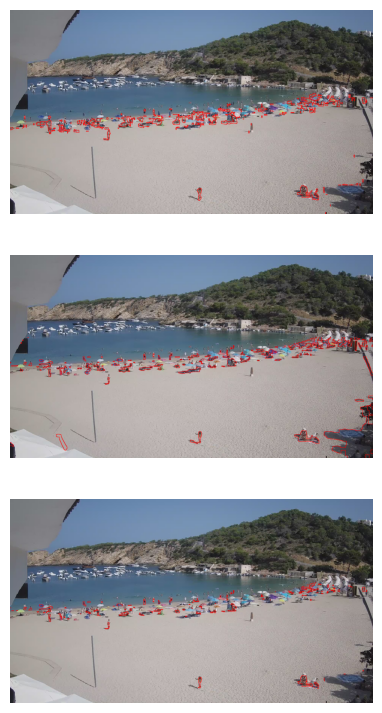

In [49]:
index = 4

fig = plt.figure()
fig.add_subplot(3,1,1)
plt.imshow(results_method_1[index])
plt.axis("off")

fig.add_subplot(3,1,2)
plt.imshow(results_method_2[index])
plt.axis("off")

fig.add_subplot(3,1,3)
plt.imshow(results_and_1_2[index])
plt.axis("off")

## Evaluation

In [22]:
from sklearn.neighbors import NearestNeighbors

In [88]:
def eval_images_mse(gt, detections):
    return np.mean(np.square(gt - detections))

num_detections = [len(x) for x in centroids_result]
eval_images_mse(gt_count["NPeople"], num_detections)

2164.4

In [89]:
errors = []
for i in range(len(num_detections)):
    errors.append(np.abs(gt_count["NPeople"][i] - num_detections[i]))
errors

[6, 0, 23, 1, 48, 59, 102, 56, 32, 27]

In [91]:
treshold = 15

scores = []

for idx, image in enumerate(gt_count["Image"].tolist()):
    predict_ = centroids_result[idx]
    if image not in np.unique(gt_positions["Image"]):
        scores.append(0)
        continue
    
    gt_ = gt_positions[gt_positions["Image"] == image][["X","Y"]].values.tolist()
    
    nbrs = NearestNeighbors(n_neighbors=1).fit(gt_)
    distances, indices = nbrs.kneighbors(predict_)
    
    scores.append(np.sum(distances < treshold) / len(predict_))

scores

[0,
 0,
 0.2765957446808511,
 0.3488372093023256,
 0.46551724137931033,
 0.4657534246575342,
 0.5393258426966292,
 0.4583333333333333,
 0.46601941747572817,
 0.4051724137931034]

In [94]:
detections_vs_gt = []

for idx, image in enumerate(gt_count["Image"].tolist()):
    predict_ = centroids_result[idx]
    canvas = results_combined[idx].copy()
    
    for cent in predict_:
        cv2.circle(canvas, (cent[0], cent[1]), 5, (0, 0, 255), -1)
    
    if image not in np.unique(gt_positions["Image"]):
        detections_vs_gt.append(canvas)
        continue
    
    gt_ = gt_positions[gt_positions["Image"] == image][["X","Y"]].values.tolist()

    for cent in gt_:
        cv2.circle(canvas, (cent[0], cent[1]), 5, (0, 255, 0), -1)
        
    detections_vs_gt.append(canvas)

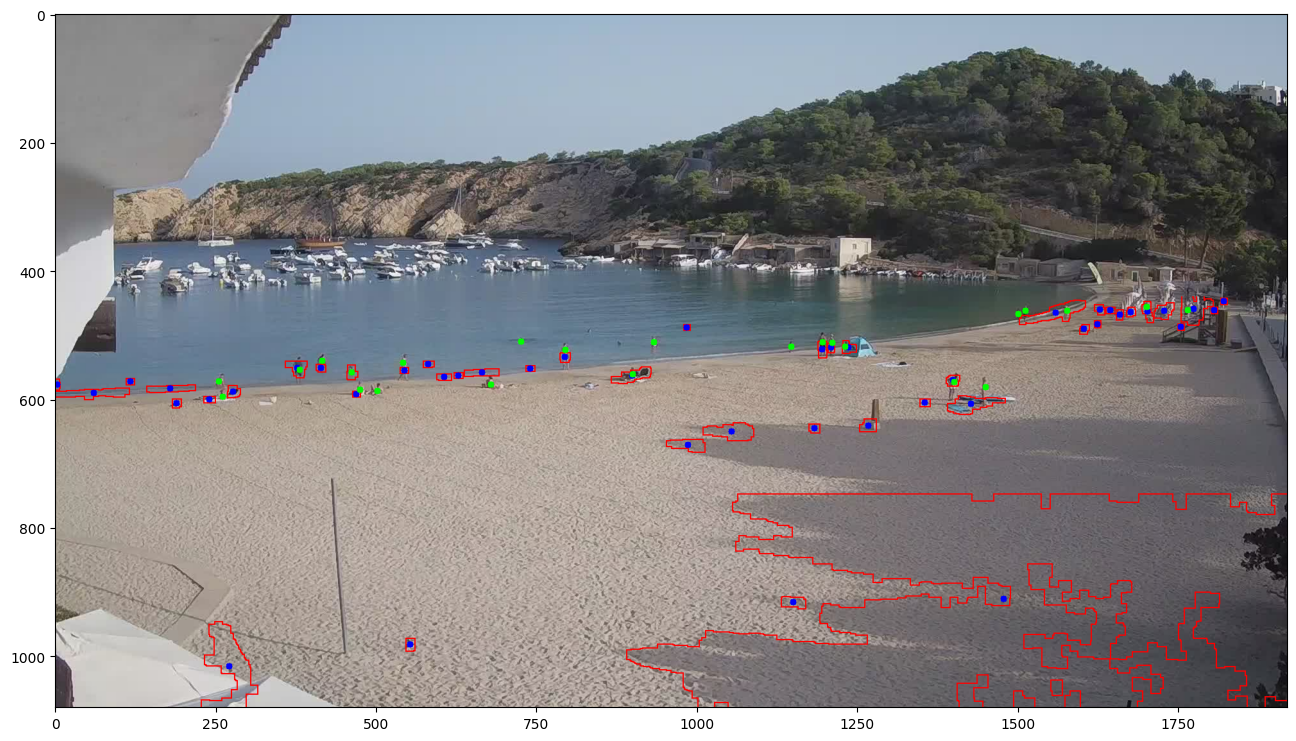

In [95]:
plt.imshow(detections_vs_gt[2])